###1.Import packages and data


In [1]:
import matplotlib.pyplot as plt
import tensorflow
import keras
from keras import metrics
import numpy as np
from scipy.spatial.distance import cdist
import pandas as pd

Using TensorFlow backend.


In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  


Saving drugTweets.txt to drugTweets.txt
User uploaded file "drugTweets.txt" with length 368650 bytes


In [3]:
drugTweets = pd.read_csv('drugTweets.txt', delimiter = "\t", header = 0)

###2.Tokenization & Split Train / Test

In [4]:
from keras.preprocessing.text import Tokenizer

In [5]:
num_words = 5000

tokenizer = Tokenizer(num_words = num_words)
tokenizer.fit_on_texts(drugTweets.text_text)


In [6]:
test = drugTweets.sample(frac = 0.2, random_state = 123)
train = drugTweets.drop(test.index)

y_train = train.abuse
y_test = test.abuse

x_test_tokens = tokenizer.texts_to_sequences(test.text_text)
x_train_tokens = tokenizer.texts_to_sequences(train.text_text)

###3.Text Padding

In [7]:
from keras.preprocessing.sequence import pad_sequences

In [8]:
num_tokens = [len(tokens) for tokens in x_train_tokens + x_test_tokens]
num_tokens = np.array(num_tokens)

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens


26

In [9]:
np.sum(num_tokens < max_tokens) / len(num_tokens)

0.9559164733178654

In [10]:
pad = 'post'

x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens,
                            padding=pad, truncating=pad)

x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens,
                           padding=pad, truncating=pad)



###4.RNN 

In [11]:
from keras.models import Sequential
from keras.layers import Dense, GRU, LSTM, Dropout
from keras.regularizers import l1, l2

from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.utils import class_weight


In [12]:
embedding_size = 64

In [13]:
rnn = Sequential()

rnn.add(Embedding(input_dim = num_words,
                 output_dim = embedding_size,
                 input_length = max_tokens,
                 name = "embedding_layer"))

rnn.add(Dropout(0.5))

rnn.add(LSTM(units = 16,
            dropout = 0.4,
            kernel_regularizer=l1(0.0001),
            name = 'LSTM_layer'))

rnn.add(Dropout(0.5))
rnn.add(Dropout(0.1))

rnn.add(Dense(units = 1,
             activation = 'sigmoid',
             kernel_regularizer=l2(0.015),
             name = 'Ouput_Layer'))


optimizer = Adam(lr = 0.001, decay = 0.001)

rnn.compile(loss = 'binary_crossentropy',
           optimizer = optimizer,
           metrics = ['accuracy'])

In [14]:
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(y_train),
                                                  y_train)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.5847868217054264, 1: 3.4485714285714284}

####Training

In [22]:
rnn.fit(x_train_pad, y_train, batch_size = 64, validation_split = 0.02, epochs = 2, class_weight = class_weights)
preds_train = rnn.predict_classes(x_train_pad)
print(classification_report(y_train, preds_train, digits = 3))

Train on 2365 samples, validate on 49 samples
Epoch 1/2
2365/2365 [==============================] - 1s 326us/step - loss: 0.3060 - accuracy: 0.9467 - val_loss: 1.9967 - val_accuracy: 0.8163
Epoch 2/2
2365/2365 [==============================] - 1s 319us/step - loss: 0.2526 - accuracy: 0.9569 - val_loss: 1.9413 - val_accuracy: 0.7959
              precision    recall  f1-score   support

           0      0.988     0.986     0.987      2064
           1      0.918     0.929     0.923       350

    accuracy                          0.978      2414
   macro avg      0.953     0.957     0.955      2414
weighted avg      0.978     0.978     0.978      2414



#### Test

In [23]:
preds = rnn.predict_classes(x_test_pad)
print(classification_report(y_test, preds, digits = 3))


              precision    recall  f1-score   support

           0      0.883     0.897     0.890       506
           1      0.416     0.381     0.398        97

    accuracy                          0.814       603
   macro avg      0.649     0.639     0.644       603
weighted avg      0.808     0.814     0.811       603



Check confusion_matrix of RNN model.

In [24]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, preds)

array([[454,  52],
       [ 60,  37]])

In [28]:
rnn.fit(x_train_pad, y_train, batch_size=64,
          validation_split=0.05, epochs=20)
preds = rnn.predict_classes(x_test_pad)
print(classification_report(y_test, preds, digits = 3))

Train on 2293 samples, validate on 121 samples
Epoch 1/20
2293/2293 [==============================] - 1s 305us/step - loss: 0.0941 - accuracy: 0.9926 - val_loss: 0.6975 - val_accuracy: 0.8347
Epoch 2/20
2293/2293 [==============================] - 1s 312us/step - loss: 0.0955 - accuracy: 0.9904 - val_loss: 0.6995 - val_accuracy: 0.8347
Epoch 3/20
2293/2293 [==============================] - 1s 302us/step - loss: 0.1057 - accuracy: 0.9865 - val_loss: 0.6947 - val_accuracy: 0.8182
Epoch 4/20
2293/2293 [==============================] - 1s 309us/step - loss: 0.1018 - accuracy: 0.9887 - val_loss: 0.6965 - val_accuracy: 0.8182
Epoch 5/20
2293/2293 [==============================] - 1s 312us/step - loss: 0.0952 - accuracy: 0.9904 - val_loss: 0.7042 - val_accuracy: 0.8264
Epoch 6/20
2293/2293 [==============================] - 1s 310us/step - loss: 0.0979 - accuracy: 0.9922 - val_loss: 0.7115 - val_accuracy: 0.8182
Epoch 7/20
2293/2293 [==============================] - 1s 315us/step - loss:

In [31]:
cnn_mod_fit=rnn.fit(x_train_pad, y_train, batch_size=64,
          validation_split=0.05, epochs=20)
history_dict = cnn_mod_fit.history
history_dict.keys()

Train on 2293 samples, validate on 121 samples
Epoch 1/20
2293/2293 [==============================] - 1s 319us/step - loss: 0.0926 - accuracy: 0.9922 - val_loss: 0.7257 - val_accuracy: 0.8099
Epoch 2/20
2293/2293 [==============================] - 1s 320us/step - loss: 0.0942 - accuracy: 0.9930 - val_loss: 0.7238 - val_accuracy: 0.8264
Epoch 3/20
2293/2293 [==============================] - 1s 310us/step - loss: 0.0877 - accuracy: 0.9930 - val_loss: 0.7352 - val_accuracy: 0.8264
Epoch 4/20
2293/2293 [==============================] - 1s 317us/step - loss: 0.0933 - accuracy: 0.9930 - val_loss: 0.7122 - val_accuracy: 0.8099
Epoch 5/20
2293/2293 [==============================] - 1s 329us/step - loss: 0.0863 - accuracy: 0.9926 - val_loss: 0.7387 - val_accuracy: 0.8264
Epoch 6/20
2293/2293 [==============================] - 1s 314us/step - loss: 0.0863 - accuracy: 0.9926 - val_loss: 0.7393 - val_accuracy: 0.8264
Epoch 7/20
2293/2293 [==============================] - 1s 315us/step - loss:

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

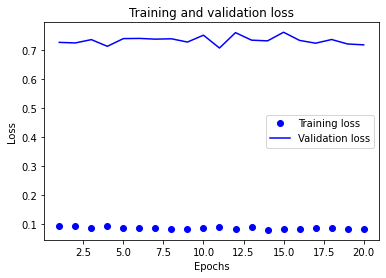

In [33]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

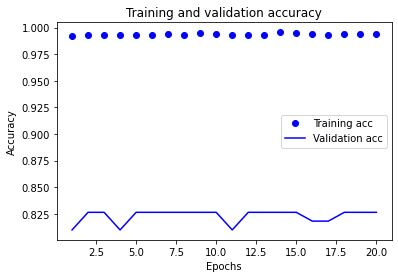

In [34]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

###5.CNN

In [35]:
from keras.layers import Conv1D, GlobalMaxPooling1D, Dropout

In [36]:
embedding_size = 32

In [37]:
cnn = Sequential()
cnn.add(Embedding(input_dim=num_words,
                    output_dim=embedding_size,
                    input_length=max_tokens,
                    name='Embedding_layer'))

cnn.add(Conv1D(filters=32, 
               kernel_size=7, 
               activation='relu',
               name='Conv_Layer'))

cnn.add(GlobalMaxPooling1D(name='Pooling_Layer'))

cnn.add(Dense(units=100,
              activation='relu',
              name='Dense_Layer'))

cnn.add(Dense(units=1,
              activation='sigmoid',
              name='Dense_Output_Layer'))

cnn.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#### Training

In [38]:
cnn.fit(x_train_pad, y_train, batch_size = 16,
          validation_split=0.02, epochs= 2, class_weight = class_weights)
cnn.evaluate(x_train_pad, y_train)
preds_cnn_train = cnn.predict_classes(x_train_pad)
print(classification_report(y_train, preds_cnn_train, digits=3))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2365 samples, validate on 49 samples
Epoch 1/2
2365/2365 [==============================] - 1s 339us/step - loss: 0.6867 - accuracy: 0.5501 - val_loss: 0.7911 - val_accuracy: 0.5510
Epoch 2/2
2414/2414 [==============================] - 0s 33us/step
              precision    recall  f1-score   support

           0      0.986     0.908     0.946      2064
           1      0.632     0.926     0.751       350

    accuracy                          0.911      2414
   macro avg      0.809     0.917     0.848      2414
weighted avg      0.935     0.911     0.918      2414



#### Testing

In [39]:
cnn.evaluate(x_test_pad, y_test)
cnn_preds = cnn.predict_classes(x_test_pad)
print(classification_report(y_test, cnn_preds, digits=3))

603/603 [==============================] - 0s 53us/step
              precision    recall  f1-score   support

           0      0.891     0.836     0.862       506
           1      0.352     0.464     0.400        97

    accuracy                          0.776       603
   macro avg      0.621     0.650     0.631       603
weighted avg      0.804     0.776     0.788       603



In [40]:
cnn_mod_fit = cnn.fit(x_train_pad, y_train, batch_size=16,
          validation_split=0.05, epochs=20)

Train on 2293 samples, validate on 121 samples
Epoch 1/20
2293/2293 [==============================] - 1s 257us/step - loss: 0.1486 - accuracy: 0.9451 - val_loss: 0.4793 - val_accuracy: 0.8760
Epoch 2/20
2293/2293 [==============================] - 1s 251us/step - loss: 0.0546 - accuracy: 0.9856 - val_loss: 0.5670 - val_accuracy: 0.8678
Epoch 3/20
2293/2293 [==============================] - 1s 254us/step - loss: 0.0170 - accuracy: 0.9969 - val_loss: 0.7010 - val_accuracy: 0.8347
Epoch 4/20
2293/2293 [==============================] - 1s 250us/step - loss: 0.0088 - accuracy: 0.9983 - val_loss: 0.7574 - val_accuracy: 0.8512
Epoch 5/20
2293/2293 [==============================] - 1s 263us/step - loss: 0.0056 - accuracy: 0.9987 - val_loss: 0.8685 - val_accuracy: 0.8264
Epoch 6/20
2293/2293 [==============================] - 1s 259us/step - loss: 0.0036 - accuracy: 0.9987 - val_loss: 0.9252 - val_accuracy: 0.8264
Epoch 7/20
2293/2293 [==============================] - 1s 259us/step - loss:

In [41]:
history_dict = cnn_mod_fit.history
history_dict.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

#### Testing

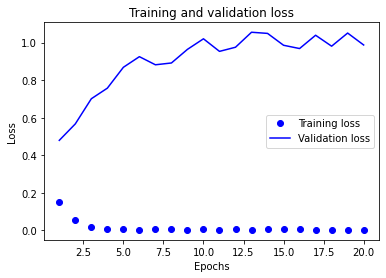

In [43]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

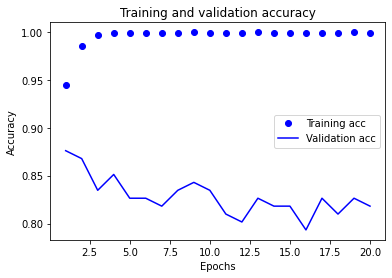

In [44]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()